#Classification, CNN, Computer Vision Example

## Problem Statement

### Objective

- Develop a machine learning model that can classify images of industrial
equipment into two categories: 'defective' and 'non-defective'.

### Tasks


- Select or create a dataset that includes images of industrial equipment labelled as 'defective' or 'non-defective', with additional labels for the type of defect in defective images.
- Train a machine learning model to classify images into the two main categories.
- Evaluate the model's performance using classification metrics such as accuracy,
precision, and recall.

### Deliverables

- A Jupyter notebook or Python script with the code for data preprocessing,
model training, and evaluation.
- A report summarizing the methodology, model performance, and insights
gained from the analysis.

## Setting up the requirements

### Importing necessary libraries

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
import random                                                                                    # Imposrting random to randomly choose images
from PIL import Image


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Creating the image and label datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Introduction to chosen dataset

- In this project I choose to study a dataset of hot-rolled steel sheet surface and classify the images based on whether the image is of a defective sheet or not.
- The defective imagaes are obtained from the NEU surface defect database downloaded from the link : https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database/data
- The non-defective images are generated by augmenting 5 chosen images or non defective steel sheets.

#### checking the size of 1 image as a numpy array

In [ ]:
# Open an image file
image = Image.open('crazing_1.jpg')

# Convert the image to a NumPy array
image_array = np.array(image)

# Display the shape of the array
print(image_array.shape)
# This will output something like (height, width, channels)

# Optionally: Display the image to verify
image.show()

(200, 200, 3)


#### Generating train images for non-defective images:

In [ ]:
# Paths to the reference images
reference_images_paths = [
    "1.jpg",
    "2.jpg",
    "3.jpg",
    "4.jpg",
    "5.jpg",
]

# Load all reference images
reference_images = [cv2.imread(img_path) for img_path in reference_images_paths]

# Create a directory to save the generated images
output_dir = "generated_steel_images/train"
os.makedirs(output_dir, exist_ok=True)

# Generate 240 variations
for i in range(240):
    # Randomly select one of the reference images
    reference_image = random.choice(reference_images)

    # Apply random transformations for variation
    transformed_image = cv2.GaussianBlur(reference_image, (5, 5), 0)  # Add slight blur
    brightness_factor = np.random.uniform(0.8, 1.2)
    transformed_image = cv2.convertScaleAbs(transformed_image, alpha=brightness_factor, beta=0)

    # Add random noise
    noise = np.random.normal(0, 10, transformed_image.shape).astype(np.uint8)
    transformed_image = cv2.addWeighted(transformed_image, 0.9, noise, 0.1, 0)

    # Resize the image to 128x128 pixels
    resized_image = cv2.resize(transformed_image, (200, 200), interpolation=cv2.INTER_AREA)

    # Save the image in .jpg format
    output_path = os.path.join(output_dir, f"steel_image_{i+1}.jpg")
    cv2.imwrite(output_path, resized_image)

print(f"Generated 240 images of size 200x200 saved to '{output_dir}'")

#### Generating test images for non-defective images

In [ ]:
# Paths to the reference images
reference_images_paths = [
    "1.jpg",
    "2.jpg",
    "3.jpg",
    "4.jpg",
    "5.jpg",
]

# Load all reference images
reference_images = [cv2.imread(img_path) for img_path in reference_images_paths]

# Create a directory to save the generated images
output_dir = "generated_steel_images/test"
os.makedirs(output_dir, exist_ok=True)

# Generate 240 variations
for i in range(60):
    # Randomly select one of the reference images
    reference_image = random.choice(reference_images)

    # Apply random transformations for variation
    transformed_image = cv2.GaussianBlur(reference_image, (5, 5), 0)  # Add slight blur
    brightness_factor = np.random.uniform(0.8, 1.2)
    transformed_image = cv2.convertScaleAbs(transformed_image, alpha=brightness_factor, beta=0)

    # Add random noise
    noise = np.random.normal(0, 10, transformed_image.shape).astype(np.uint8)
    transformed_image = cv2.addWeighted(transformed_image, 0.9, noise, 0.1, 0)

    # Resize the image to 128x128 pixels
    resized_image = cv2.resize(transformed_image, (200, 200), interpolation=cv2.INTER_AREA)

    # Save the image in .jpg format
    output_path = os.path.join(output_dir, f"steel_image_{i+1}.jpg")
    cv2.imwrite(output_path, resized_image)

print(f"Generated 60 images of size 200x200 saved to '{output_dir}'")

#### Creating a numpy array of train images

In [ ]:
# List of folders to process
image_folders = [
    "NEU-DET/train/images/crazing",
    "NEU-DET/train/images/inclusion",
    "NEU-DET/train/images/patches",
    "NEU-DET/train/images/pitted_surface",
    "NEU-DET/train/images/rolled-in_scale",
    "NEU-DET/train/images/scratches",
    "generated_steel_images/train"
]

output_file = "images_train.npy"

# Initialize a list to hold the image arrays
image_arrays = []
# Iterate through each folder
for folder in image_folders:
    print(f"Processing folder: {folder}")
    image_folder = folder

    # Iterate through the images in the folder
    for idx, filename in enumerate(os.listdir(image_folder)):
        if filename.endswith(('.jpg')):  # Include common image formats
            image_path = os.path.join(image_folder, filename)
            try:
                # Open the image file
                with Image.open(image_path) as img:
                    # Convert the image to a NumPy array
                    image_array = np.array(img)

                    # Ensure all images are of the same size (resize to a consistent size if needed)
                    desired_size = (200, 200)  # Adjust the desired size as needed
                    img_resized = img.resize(desired_size)
                    image_array = np.array(img_resized)

                    # Add the image array to the list
                    image_arrays.append(image_array)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

        # Stop after processing 240 images
        #if len(image_arrays) == 240:
           # break

# Convert the list of image arrays into a single NumPy array
images_train = np.array(image_arrays)

# Save the array to a .npy file
np.save(output_file, images_train)

print(f"Saved {len(image_arrays)} images to '{output_file}'")

In [ ]:
print(images_train.shape)
print(len(images_train))

(1680, 200, 200, 3)
1680


#### Creating a numpy array of test images

In [ ]:
# List of folders to process
image_folders = [
    "NEU-DET/test/images/crazing",
    "NEU-DET/test/images/inclusion",
    "NEU-DET/test/images/patches",
    "NEU-DET/test/images/pitted_surface",
    "NEU-DET/test/images/rolled-in_scale",
    "NEU-DET/test/images/scratches",
    "generated_steel_images/test"
]

output_file = "images_test.npy"

# Initialize a list to hold the image arrays
image_arrays = []
# Iterate through each folder
for folder in image_folders:
    print(f"Processing folder: {folder}")
    image_folder = folder

    # Iterate through the images in the folder
    for idx, filename in enumerate(os.listdir(image_folder)):
        if filename.endswith(('.jpg')):  # Include common image formats
            image_path = os.path.join(image_folder, filename)
            try:
                # Open the image file
                with Image.open(image_path) as img:
                    # Convert the image to a NumPy array
                    image_array = np.array(img)

                    # Ensure all images are of the same size (resize to a consistent size if needed)
                    desired_size = (200, 200)  # Adjust the desired size as needed
                    img_resized = img.resize(desired_size)
                    image_array = np.array(img_resized)

                    # Add the image array to the list
                    image_arrays.append(image_array)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

        # Stop after processing 240 images
        #if len(image_arrays) == 240:
           # break

# Convert the list of image arrays into a single NumPy array
images_test = np.array(image_arrays)

# Save the array to a .npy file
np.save(output_file, images_test)

print(f"Saved {len(image_arrays)} images to '{output_file}'")

In [ ]:
print(images_test.shape)
print(len(images_test))

(420, 200, 200, 3)
420


#### Creating the labels for the train and test datasets

In [ ]:
import csv

# Define the categories for the first and second columns
labels_1 = ['defective'] * 1440 + ['non-defective'] * 240
labels_2 = ['crazing'] * 240 + ['inclusion'] * 240 + ['patches'] * 240 + ['pitted_surface'] * 240 + ['rolled-in_scale'] * 240 + ['scratches'] * 240 + ['no-defect'] * 240  # 240 entries for each category

# Ensure the lengths match
assert len(labels_1) == len(labels_2)

# Write to CSV file
filename = 'Labels_train.csv'
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Label_1', 'Label_2'])  # Write header
    for label_1, label_2 in zip(labels_1, labels_2):
        writer.writerow([label_1, label_2])

print(f'{filename} has been created successfully!')


In [ ]:
labels_train = pd.read_csv('Labels_train.csv')

In [ ]:
import csv

# Define the categories for the first and second columns
labels_1 = ['defective'] * 360 + ['non-defective'] * 60
labels_2 = ['crazing'] * 60 + ['inclusion'] * 60 + ['patches'] * 60 + ['pitted_surface'] * 60 + ['rolled-in_scale'] * 60 + ['scratches'] * 60 + ['no-defect'] * 60  # 60 entries for each category

# Ensure the lengths match
assert len(labels_1) == len(labels_2)

# Write to CSV file
filename = 'Labels_test.csv'
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Label_1', 'Label_2'])  # Write header
    for label_1, label_2 in zip(labels_1, labels_2):
        writer.writerow([label_1, label_2])

print(f'{filename} has been created successfully!')


In [ ]:
labels_test = pd.read_csv('Labels_test.csv')

In [ ]:
labels_train

,Label_1,Label_2
0,defective,crazing
1,defective,crazing
2,defective,crazing
3,defective,crazing
4,defective,crazing
...,...,...
1675,non-defective,no-defect
1676,non-defective,no-defect
1677,non-defective,no-defect
1678,non-defective,no-defect


In [ ]:
labels_test

,Label_1,Label_2
0,defective,crazing
1,defective,crazing
2,defective,crazing
3,defective,crazing
4,defective,crazing
...,...,...
415,non-defective,no-defect
416,non-defective,no-defect
417,non-defective,no-defect
418,non-defective,no-defect


## Data Overview

### Understand the shape of the dataset

In [ ]:
print(images_train.shape)
print(labels_train.shape)

(1680, 200, 200, 3)
(1680, 2)


In [ ]:
print(images_test.shape)
print(labels_test.shape)

(420, 200, 200, 3)
(420, 2)


There are 1680 images in the train set and 420 images in the test set each of shape 200 x 200 X 3.

## Exploratory Data Analysis

##### Useful functions

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Checking the distribution of various labels in the dataset

In [ ]:
labels_train['Label_1'].value_counts()

,count
Label_1,
defective,1440
non-defective,240


In [ ]:
labels_train['Label_2'].value_counts()

,count
Label_2,
crazing,240
inclusion,240
patches,240
pitted_surface,240
rolled-in_scale,240
scratches,240
no-defect,240


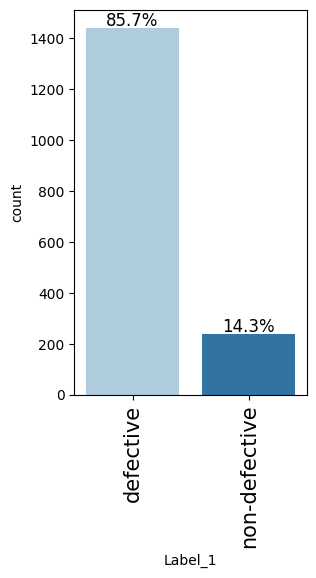

In [ ]:
labeled_barplot(labels_train, "Label_1", perc=True)

- The defective vs non-defective data set is imbalanced with more number of defective images

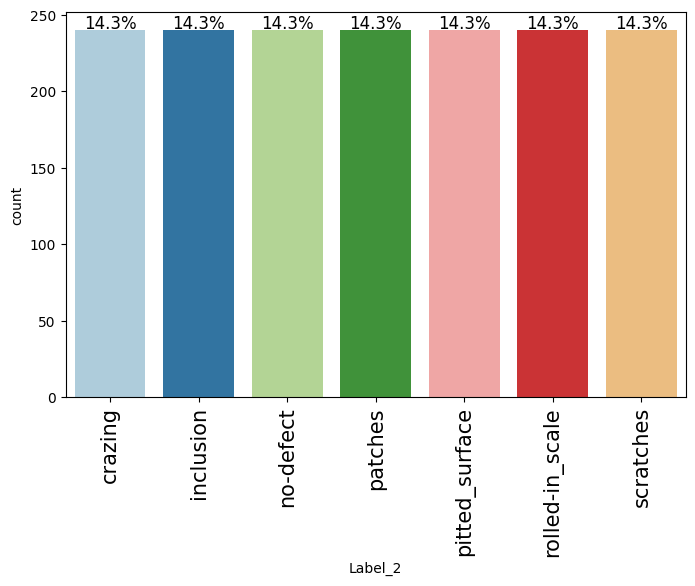

In [ ]:
labeled_barplot(labels_train, "Label_2", perc=True)

### Checking the unique labels in the dataset and visualising examples of each

In [ ]:
unique_labels_1 = labels_train['Label_1'].unique()
for i in range(len(unique_labels_1)):
  print(unique_labels_1[i])

defective
non-defective


In [ ]:
unique_labels_2 = labels_train['Label_2'].unique()
for i in range(len(unique_labels_2)):
  print(unique_labels_2[i])

crazing
inclusion
patches
pitted_surface
rolled-in_scale
scratches
no-defect


In [ ]:
def plot_images_1(images,labels):
  num_classes=2                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels_train['Label_1'])                                                      # Obtaing the unique classes from y_train
  rows = 1                                                                        # Defining number of rows=3
  cols = 2                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(15, 12))                                              # Defining the figure size to 10x8

  # Select images for current category
  category_index = 0
  for i in range(cols):
      for j in range(rows):
          # Check if category_index is within bounds
          if category_index >= len(unique_labels_2):
            break  # Exit inner loop if category_index exceeds the limit
          check = 0                                                              #Finding a random image of a particular species
          while check == 0:
            random_index = np.random.randint(0, len(labels_train['Label_1']))
            if keys[random_index] != unique_labels_1[category_index]:
              random_index = np.random.randint(0, len(labels_train['Label_1']))
            else:
              check = 1

          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
          check = 0
          category_index += 1
  plt.show()

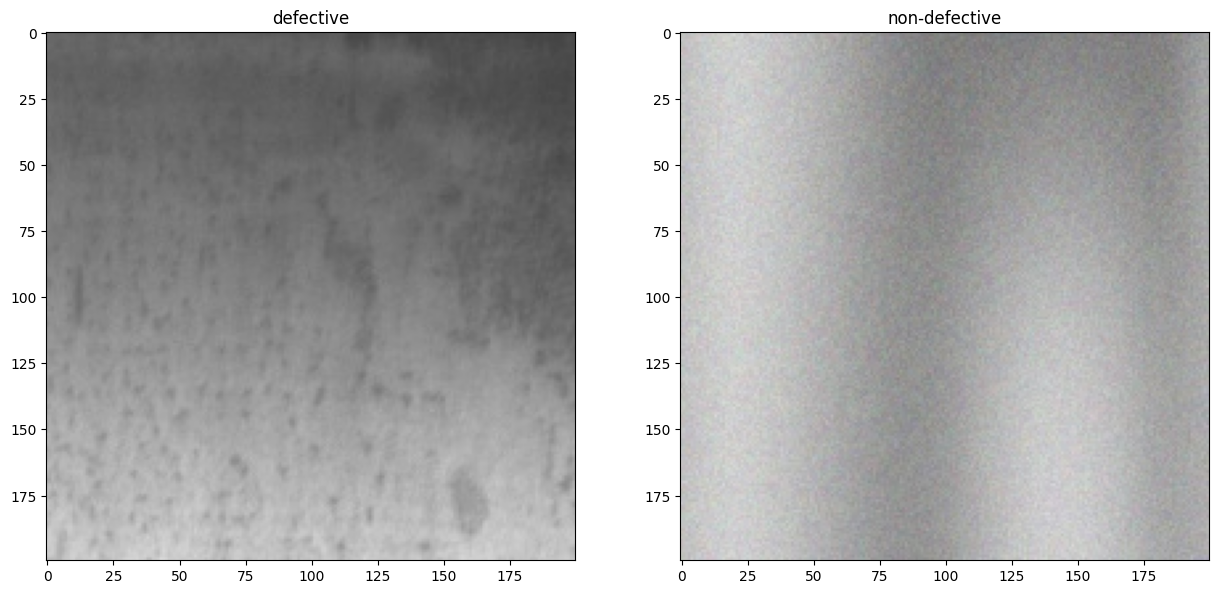

In [ ]:
plot_images_1(images_train,labels_train['Label_1'])

In [ ]:
def plot_images_2(images,labels):
  num_classes=7                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels_train['Label_2'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 3                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(15, 12))                                              # Defining the figure size to 10x8

  # Select images for current category
  category_index = 0
  for i in range(cols):
      for j in range(rows):
          # Check if category_index is within bounds
          if category_index >= len(unique_labels_2):
            break  # Exit inner loop if category_index exceeds the limit
          check = 0                                                              #Finding a random image of a particular species
          while check == 0:
            random_index = np.random.randint(0, len(labels_train['Label_2']))
            if keys[random_index] != unique_labels_2[category_index]:
              random_index = np.random.randint(0, len(labels_train['Label_2']))
            else:
              check = 1

          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
          check = 0
          category_index += 1
  plt.show()

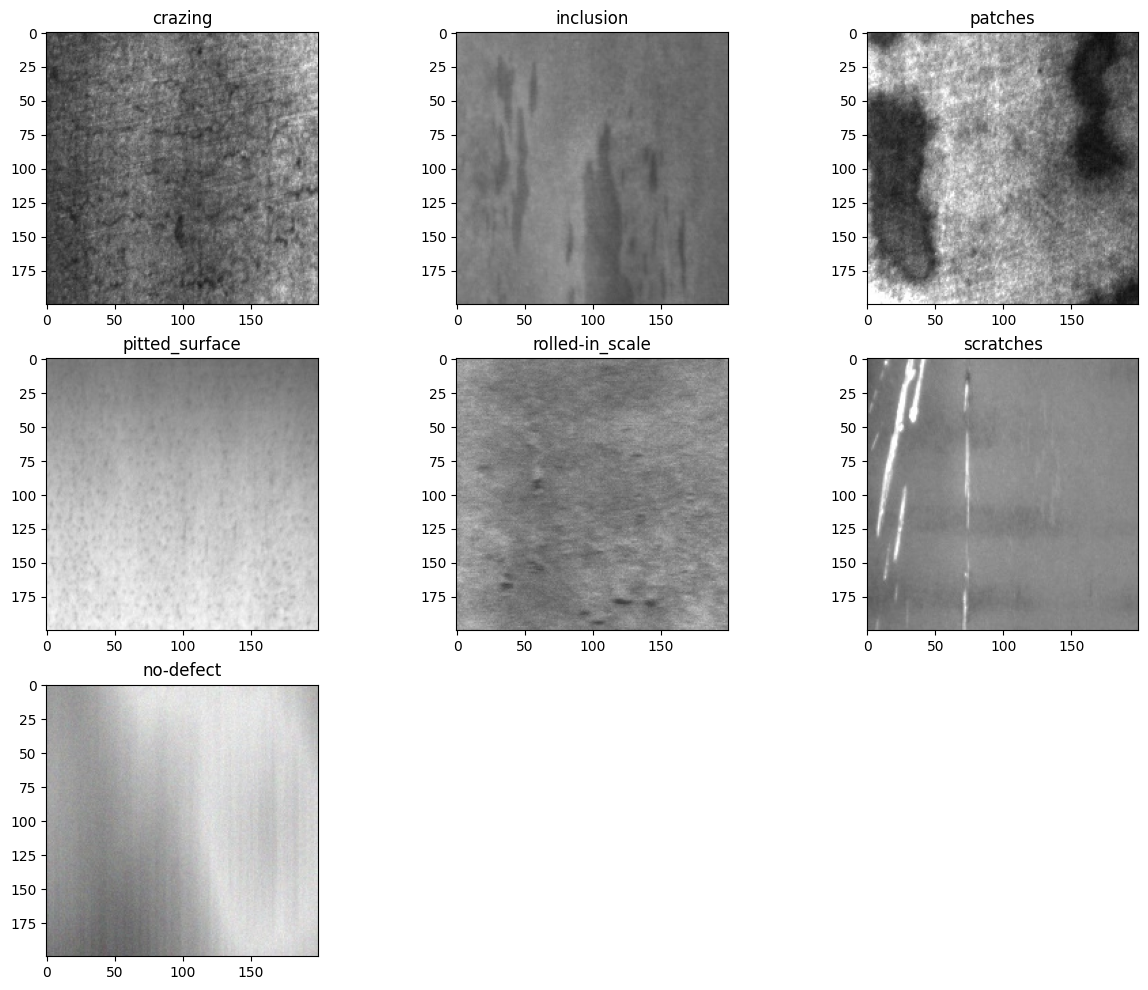

In [ ]:
plot_images_2(images_train,labels_train['Label_2'])

## Data Pre-Processing

- Splitting the data into train, test, and validation to be able to evaluate the model that you build on the train data
- I encode categorical features and scale the pixel values.
- Further , I build a model using the train data and then check its performance on the validation data

### Splitting the dataset in Train, Test and Validation Sets


- 10% of the train data is used for validation and 90% of the train data for training.

In [ ]:
X = images_train
Y = labels_train['Label_1']

In [ ]:
X_test = images_test
y_test = labels_test['Label_1']

In [ ]:
type(X)

numpy.ndarray

In [ ]:
Y

,Label_1
0,defective
1,defective
2,defective
3,defective
4,defective
...,...
1675,non-defective
1676,non-defective
1677,non-defective
1678,non-defective


In [ ]:
Y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1680 entries, 0 to 1679
Series name: Label_1
Non-Null Count  Dtype 
--------------  ----- 
1680 non-null   object
dtypes: object(1)
memory usage: 13.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,Y , test_size=0.1, random_state=42,stratify=Y)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(1512, 200, 200, 3) (1512,)
(168, 200, 200, 3) (168,)
(420, 200, 200, 3) (420,)


- The training, validating and testing datasets in X and Y have 1512, 168 and 420 samples respectively.
- All the images are of 200x200 pixels and have all 3 RGB channels.

### Encode the target labels

In [ ]:
# Convert labels from names to one hot vectors.
# Using the labelBinarizer method

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [ ]:
np.unique(y_test_encoded)

array([0, 1])

### Data Normalization

In [ ]:
# Normalizing the image pixels using the scaling technique, dividing each pixel by 255 (Since the pixel values are in the range 0-255)
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [ ]:
print(X_train_normalized.shape,y_train_encoded.shape)
print(X_val_normalized.shape,y_val_encoded.shape)
print(X_test_normalized.shape,y_test_encoded.shape)

(1512, 200, 200, 3) (1512, 1)
(168, 200, 200, 3) (168, 1)
(420, 200, 200, 3) (420, 1)


## **Model Building**

- Setting the random numbers for reproducability of the code

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Model 1 - Convolutional Neural Network (CNN)

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

Building  a CNN Model with the following 2 main parts - <br>

1. 'The Feature Extraction layers'
  - It comprises 3 convolutional layers with 64, 32 and 16 filters with a 3x3 kernal size respectively, followed by max-pooling layers.
  - The 'Relu' activation function is used and the same padding is applied to ensure same output size as the input.
2. 'The Fully Connected classification layers' for prediction.
  - It consists of a fully connected dense layer with 16 neurons and a drop-out layer with 30% drop out to prevent over-fitting.
  - The final output layer consists of 1 neuron corrsponding to whether the image is defective or not.
  - Adam Optimizer is used in the final model.
  - The binary_crossentropy loss method is used since it is a binary-classification problem.

In [ ]:
# Intializing a sequential model
model1 = Sequential()

## The Feature Extraction layers

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(200, 200, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

#2nd conv layer with 32 filters
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

#3rd conv layer with 16 filters
model1.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

## The Fully Connected classification layers

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

# Adding the output layer with 1 neurons and activation functions as sigmoid since this is a binary-class classification problem
model1.add(Dense(1, activation='sigmoid'))

# Using Adam Optimizer
opt=Adam()
# Compile model
model1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Generating the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,913 (722.32 KB)

 Trainable params: 184,913 (722.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Fitting the model on the train data
history1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=16,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
)

Epoch 1/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.8452 - loss: 0.4869 - precision: 0.3333 - recall: 0.0711 - val_accuracy: 0.8571 - val_loss: 0.3963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8567 - loss: 0.4165 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.5235 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8567 - loss: 0.4364 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.4056 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8567 - loss: 0.3688 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.3254 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8567 - loss: 0.3350 - precision: 0.0000e

#### Evaluation of Model 1 by plotting accuracy, loss, precision and recall

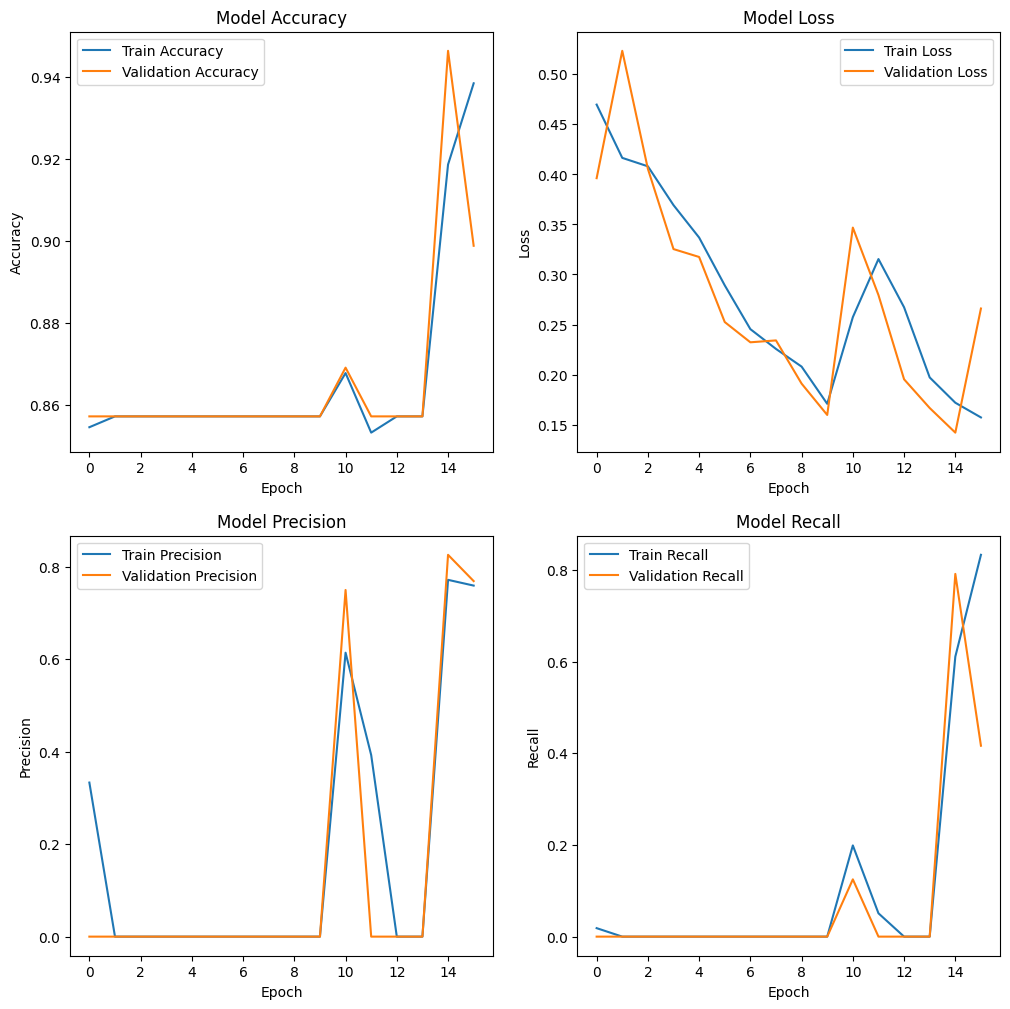

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation precision values
plt.subplot(2, 2, 3)
plt.plot(history1.history['precision'], label='Train Precision')
plt.plot(history1.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation recall values
plt.subplot(2, 2, 4)
plt.plot(history1.history['recall'], label='Train Recall')
plt.plot(history1.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Observations:**


- The model attains good accuracy, precision and recall values and low values of loss.


In [ ]:
#Checking the accuracy of the model in the test dataset
result1 = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

14/14 - 0s - 28ms/step - accuracy: 0.9024 - loss: 0.2076 - precision: 0.7568 - recall: 0.4667


In [ ]:
print(f"Loss: {result1[0]}")
print(f"Accuracy: {result1[1]}")
print(f"Precision: {result1[2]}")
print(f"Recall: {result1[3]}")

Loss: 0.20764872431755066
Accuracy: 0.9023809432983398
Precision: 0.7567567825317383
Recall: 0.46666666865348816


- Model 1 shows an accuracy of 90.2% which is good and a loss of 0.27 which is ok.
- The precision and recall values can be improved.

#### Generating the predictions from Model 1 using test data

In [ ]:
#Running the model 1 on the test dataset
y_pred1 = model1.predict(X_test_normalized)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [ ]:
y_pred1_classes = (y_pred1 > 0.5).astype(int)  # Convert probabilities to binary classes

#### Plotting the confusion matrix to analyse the performance of Model 1 on the test dataset

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred1_classes)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[351   9]
 [ 32  28]]


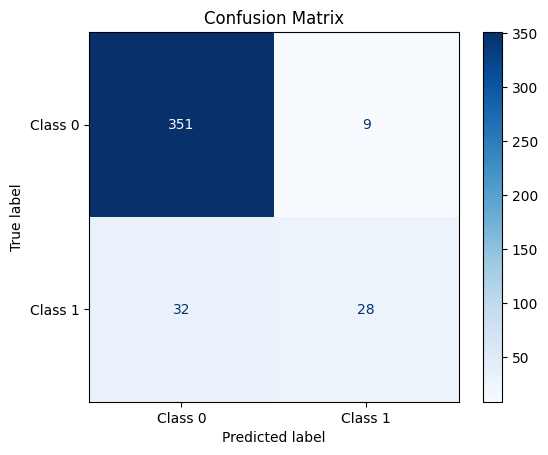

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

- The confusion matrix shows that the model predicts most of the instances with good accuracy
- However there are also a few instances of wrong prediction.

## Model Performance Improvement by Reduced Learning Rate

In [ ]:
# Clear session
backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Model 2 - Reduced Learning Rate

In [ ]:
# Intializing a sequential model
model2 = Sequential()

## The Feature Extraction layers

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(200, 200, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

#2nd conv layer with 32 filters
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

#3rd conv layer with 16 filters
model2.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

## The Fully Connected classification layers

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))

# Adding the output layer with 1 neurons and activation functions as sigmoid since this is a binary-class classification problem
model2.add(Dense(1, activation='sigmoid'))

# Using Adam Optimizer
opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,913 (722.32 KB)

 Trainable params: 184,913 (722.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Import the ReduceLROnPlateau callback from Keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Initialize ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',     # Monitor validation accuracy
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
#Fitting the model on the train data
history2 = model2.fit(
            X_train_normalized, y_train_encoded,
            epochs=16,
            validation_data=(X_val_normalized,y_val_encoded),
            callbacks=[reduce_lr],
            batch_size=32,
)

Epoch 1/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8452 - loss: 0.4867 - precision: 0.3333 - recall: 0.0711 - val_accuracy: 0.8571 - val_loss: 0.3960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8567 - loss: 0.4170 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.4402 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8567 - loss: 0.4223 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.3103 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/16
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8567 - loss: 0.3307 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.2947 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/16


#### Evaluation of Model 2 by plotting accuracy, loss, precision and recall

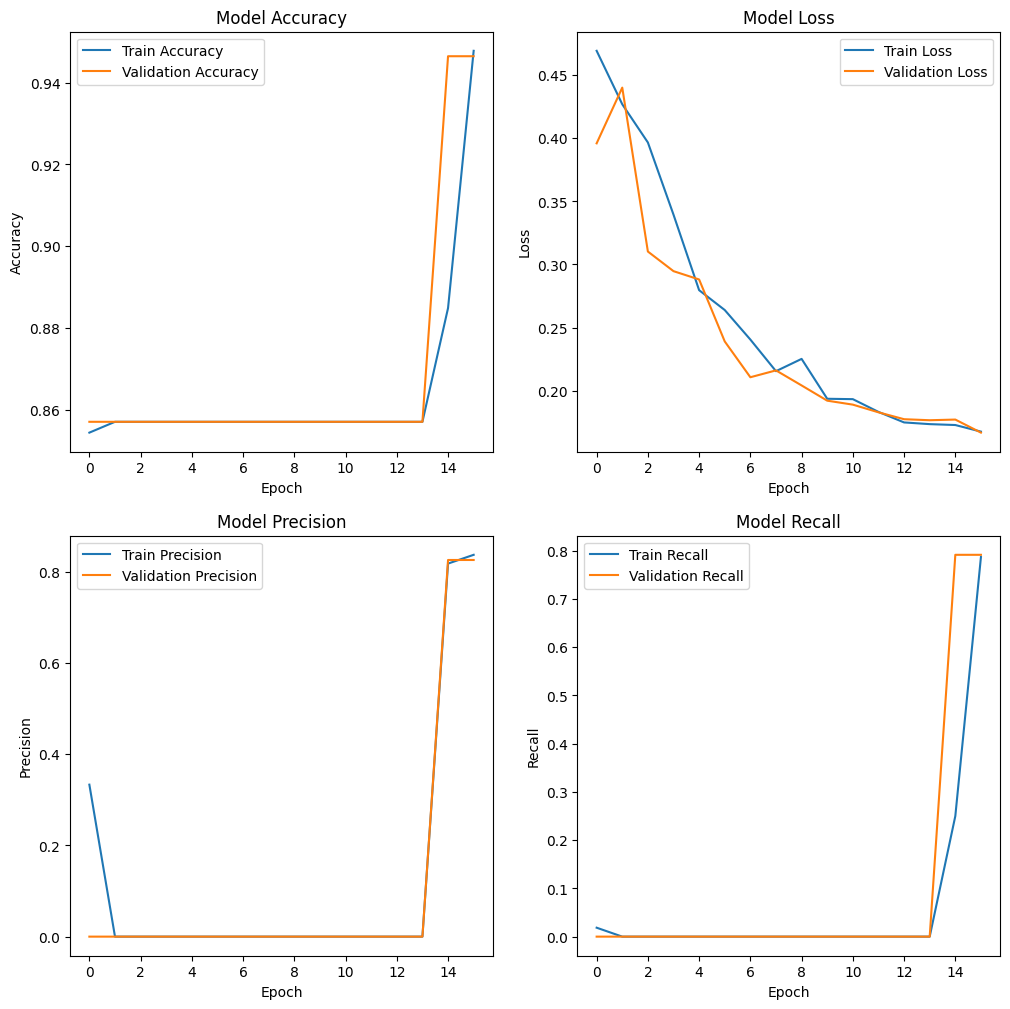

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation precision values
plt.subplot(2, 2, 3)
plt.plot(history2.history['precision'], label='Train Precision')
plt.plot(history2.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation recall values
plt.subplot(2, 2, 4)
plt.plot(history2.history['recall'], label='Train Recall')
plt.plot(history2.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.show()


**Observations:**


- The training accuracy and the validation accuracy of Model 2 shows a better trend than Model 1. The fluctutations in the accuracies have decreased
- The training and the validation losses have also decreased considerable in Model 2 in comparison to Model 1.
- The precision and recall values in Model 2 has increased significantly from Model 1.
- The overfitting has reduced in Model 2 in comparison to Model 1.


#### Evaluating the Model 2 on test data

In [ ]:
#Checking the accuracy of the model 2 in the test dataset
result2 = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

14/14 - 1s - 50ms/step - accuracy: 0.9405 - loss: 0.1765 - precision: 0.7966 - recall: 0.7833


In [ ]:
print(f"Loss: {result2[0]}")
print(f"Accuracy: {result2[1]}")
print(f"Precision: {result2[2]}")
print(f"Recall: {result2[3]}")

Loss: 0.1765320897102356
Accuracy: 0.9404761791229248
Precision: 0.7966101765632629
Recall: 0.7833333611488342


Model 2 shows an accuracy of 94% which is better than Model 1 and a loss of 0.176  which has reduced.
- The precision and recall have increased to 79.6% and 78.3%

#### Generating the predictions using test data

In [ ]:
#Running the model 1 on the test dataset
y_pred2 = model2.predict(X_test_normalized)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
y_pred2_classes = (y_pred2 > 0.5).astype(int)  # Convert probabilities to binary classes

#### Plotting the confusion matrix to analyse the performance of Model 2 on the test dataset

In [ ]:
conf_matrix2 = confusion_matrix(y_test_encoded, y_pred2_classes)

print("Confusion Matrix:")
print(conf_matrix2)

Confusion Matrix:
[[348  12]
 [ 13  47]]


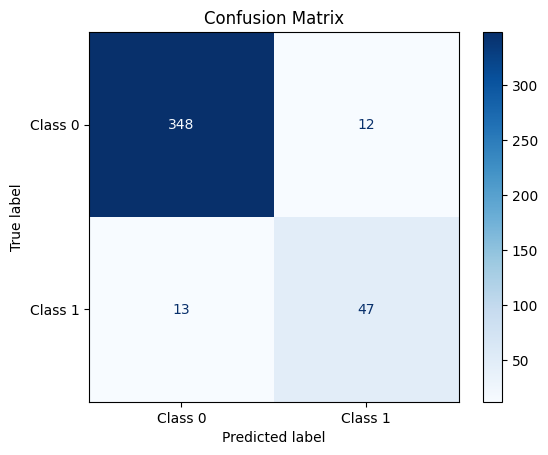

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

- The confusion matrix for Model 2 suggests that the model gives good predictions
- However there are also some mispredictions in the matrix. Overall the performance of the model has increased from Model 1.

## Final Model

#### Creating a dataframe of the results for comparison

In [ ]:
columns = ["Loss", "Accuracy", "Precision", "Recall"]

data = {
    "Model 1": result1,
    "Model 2": result2,
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data, index=columns).T  # Transpose to have metrics as columns

# Print the DataFrame
print(df)

# Optional: Save the DataFrame to a CSV file
df.to_csv("model_comparison.csv", index_label="Model")

             Loss  Accuracy  Precision    Recall
Model 1  0.207649  0.902381   0.756757  0.466667
Model 2  0.176532  0.940476   0.796610  0.783333


In [ ]:
df

,Loss,Accuracy,Precision,Recall
Model 1,0.207649,0.902381,0.756757,0.466667
Model 2,0.176532,0.940476,0.796610,0.783333


Based on the values of Model Accuracy, Loss, Precision and Recall, Model 2 seems to be performing better and can be taken as the chosen model.

## Conclusion
- From the Model Accuracy, Loss, Precision and Recall of both the models, Model 2 is the better model.
- Other techniques like training the model with Data Augmentation, or using a better model with Transfer Learning can be applied to improve the model performance.


## Visualizing the prediction

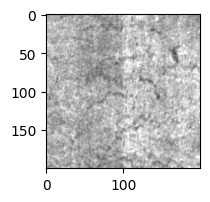

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
Predicted Label ['defective']
True Label defective


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,200,200,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector


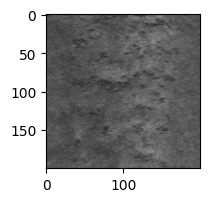

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Label ['defective']
True Label defective


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[290])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[290].reshape(1,200,200,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[290])                                              # using inverse_transform() to get the output label from the output vector


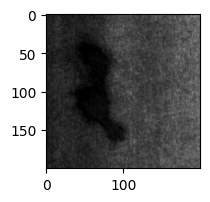

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label ['defective']
True Label defective


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[150])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[150].reshape(1,200,200,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[150])

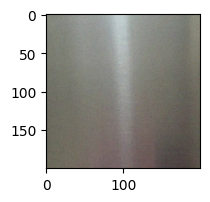

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label ['non-defective']
True Label non-defective


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[400])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[400].reshape(1,200,200,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[400])